In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.metric.metric import MetricCalculator
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.pandas_helper import get_one_row
import mesostat.stat.connectomics as connectomics

# User libraries
from lib.sych.data_fc_db import DataFCDatabase

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
params['root_path_data']  = gui_fpath("Path to data collection",  './')
#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for TE files
Total user files in dataset raw_delay_3_window_4 is 774
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

IntProgress(value=0, description='Reading TE files', max=774)

IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyos

In [7]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

In [16]:
mice48 = {'mvg4', 'mvg_7', 'mvg_8', 'mvg_9'}
mice12 = {
 'mtp_1',
 'mtp_10',
 'mtp_11',
 'mtp_12',
 'mtp_13',
 'mtp_15',
 'mtp_16',
 'mtp_2',
 'mtp_7',
 'mvg_2',
 'mvg_3',
 'mvg_5',
 'mvg_6'}

In [98]:
from scipy.stats import spearmanr, mannwhitneyu

In [77]:
import seaborn as sns

In [111]:
def fit_sliding_window(x, y, win, nStep):
    xStepLst = np.linspace(x[0], y[-1]-win, nStep)
    yStepLst = []
    for xStep in xStepLst:
        idxs = np.logical_and(x >= xStep, x <= xStep+win)
        yStepLst += [np.mean(y[idxs])]
        
    return xStepLst + win/2, np.array(yStepLst)    

nData 350 Pval 2.399550596309339e-08
0.9986681093814791


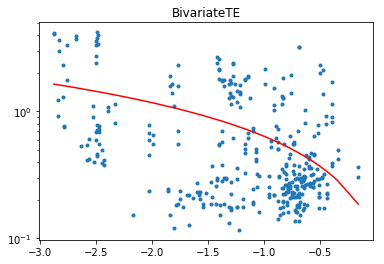

nData 350 Pval 2.935704199018951e-07
0.9986681093814791


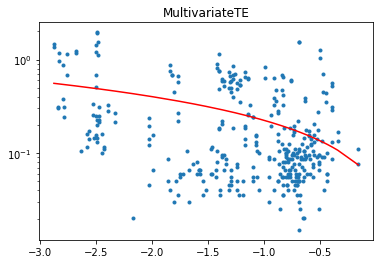

In [113]:
def test_indegree_vs_snr(mice, channelName=None):
    mc = MetricCalculator(serial=True, verbose=False)

    for methodFC in ['BivariateTE', 'MultivariateTE']:
        snrLst = []
        degLst = []
        for mousename in sorted(mice):
            sessionsDF = dataDB.get_rows('neuro', {"mousename" : mousename})
            for idxNeuro, rowNeuro in sessionsDF.iterrows():
                dataNeuro = np.copy(dataDB.dataNeuronal[idxNeuro])
                
                if channelName is not None:
                    labelsThis = dataDB.get_channel_labels(mousename)
                    idxsSpecial = np.where([l == "S1_bf" for l in labelsThis])[0]
                    dataNeuro = dataNeuro[:, :, idxsSpecial]

                # Compute channel-wise autocorrelation
                mc.set_data(dataNeuro, 'rsp')
                snrByChannel = mc.metric3D("autocorr_d1", 'p')
                
                if not isinstance(snrByChannel, np.ndarray):
                    snrByChannel = np.array([snrByChannel])

                thisSessionDFTE = dataDB.get_rows('TE', {"mousekey" : rowNeuro['mousekey'], "method" : methodFC})
                for idxTE, rowTE in thisSessionDFTE.iterrows():
                    timesFC, dataFC = dataDB.get_fc_data(idxTE, rangeSec=None)

                    # Compute average channel-wise in-degree
                    binaryConn = connectomics.is_conn(dataFC[2], 0.01)
                    inDegreeLst = [connectomics.degree_out(binaryConn[:, :, i]) for i in range(len(timesFC))]
                    avgInDegree = np.mean(inDegreeLst, axis=0)
                    
                    if channelName is None:
                        for snr, deg in zip(snrByChannel, avgInDegree):
                            snrLst += [snr]
                            degLst += [deg]
                    else:
                        for iIdx, idxSpecial in enumerate(idxsSpecial):
                            snrLst += [snrByChannel[iIdx]]
                            degLst += [avgInDegree[idxSpecial]]

        print("nData", len(snrLst), "Pval", spearmanr(snrLst, degLst)[1])

        print(np.max(snrLst))
        
        # Convert SNR to logarithmic scale
        snrLst = np.log10(1 - np.array(snrLst))
        
        # Sort in SNR-ascending order
        idxsSort = np.argsort(snrLst)
        snrLst = np.array(snrLst)[idxsSort]
        degLst = np.array(degLst)[idxsSort]
        
        plt.figure()
        plt.title(methodFC)
        plt.semilogy(snrLst, degLst, '.')

        # Fit polynomial
        coef = np.polyfit(snrLst, degLst,1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(snrLst, poly1d_fn(snrLst), 'r')

#         xFit, yFit = fit_sliding_window(np.array(snrLst), np.array(degLst), 0.5, 100)
#         plt.plot(xFit, yFit, '--r')

        plt.show()

test_indegree_vs_snr(mice12, channelName='S1_bf')

nGood 2085 nNoisy 1191 mu(good) 0.89 mu(noisy) 0.73 -log10(pVal) 9.2


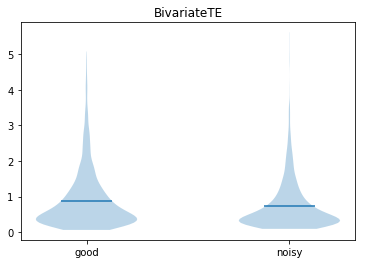

nGood 2085 nNoisy 1191 mu(good) 0.35 mu(noisy) 0.3 -log10(pVal) 7.24


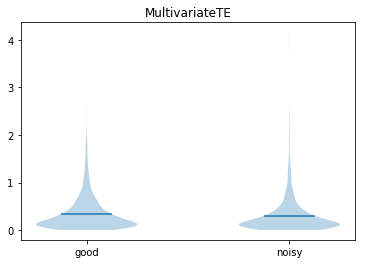

In [102]:
def test_indegree_vs_snr_blocked(mice, channelName=None):
    mc = MetricCalculator(serial=True, verbose=False)

    for methodFC in ['BivariateTE', 'MultivariateTE']:
        snrLst = []
        degLst = []
        for mousename in sorted(mice):
            sessionsDF = dataDB.get_rows('neuro', {"mousename" : mousename})
            for idxNeuro, rowNeuro in sessionsDF.iterrows():
                dataNeuro = np.copy(dataDB.dataNeuronal[idxNeuro])
                
                if channelName is not None:
                    labelsThis = dataDB.get_channel_labels(mousename)
                    idxsSpecial = np.where([l == "S1_bf" for l in labelsThis])[0]
                    dataNeuro = dataNeuro[:, :, idxsSpecial]

                # Compute channel-wise autocorrelation
                mc.set_data(dataNeuro, 'rsp')
                snrByChannel = mc.metric3D("autocorr_d1", 'p')
                
                if not isinstance(snrByChannel, np.ndarray):
                    snrByChannel = np.array([snrByChannel])

                thisSessionDFTE = dataDB.get_rows('TE', {"mousekey" : rowNeuro['mousekey'], "method" : methodFC})
                for idxTE, rowTE in thisSessionDFTE.iterrows():
                    timesFC, dataFC = dataDB.get_fc_data(idxTE, rangeSec=None)

                    # Compute average channel-wise in-degree
                    binaryConn = connectomics.is_conn(dataFC[2], 0.01)
                    inDegreeLst = [connectomics.degree_out(binaryConn[:, :, i]) for i in range(len(timesFC))]
                    avgInDegree = np.mean(inDegreeLst, axis=0)
                    
                    if channelName is None:
                        for snr, deg in zip(snrByChannel, avgInDegree):
                            snrLst += [snr]
                            degLst += [deg]
                    else:
                        for iIdx, idxSpecial in enumerate(idxsSpecial):
                            snrLst += [snrByChannel[iIdx]]
                            degLst += [avgInDegree[idxSpecial]]

        snrArr = np.array(snrLst)
        degArr = np.array(degLst)
        
        idxNoisy = snrArr < 0.9
        
        degGood = degArr[~idxNoisy]
        degNoisy = degArr[idxNoisy]
        pVal = mannwhitneyu(degGood, degNoisy, alternative="two-sided")[1]
        
        print("nGood", len(degGood),
              "nNoisy", len(degNoisy),
              "mu(good)", np.round(np.mean(degGood), 2),
              "mu(noisy)", np.round(np.mean(degNoisy), 2),
              "-log10(pVal)", np.round(-np.log10(pVal), 2))
        
#         muGood = np.mean(degGood)
#         muNoisy = np.mean(degNoisy)
#         stdGood = np.std(degGood)
#         stdNoisy = np.std(degNoisy)
        
        fig, ax = plt.subplots()
        ax.set_title(methodFC)
#         plt.violinplot(["good", "noisy"], [muGood, muNoisy], yerr=[stdGood, stdNoisy])
        ax.violinplot([degGood, degNoisy], showmeans=True, showmedians=False, showextrema=False)
        ax.set_xticks(np.arange(1,3))
        ax.set_xticklabels(["good", "noisy"])
        plt.show()
        



test_indegree_vs_snr_blocked(mice12, channelName=None)#'S1_bf')